In [1]:
# !pip install dcor
# !pip install numpy==1.20.3
# !pip install hdbscan==0.8.33
# !pip install xgboost

In [2]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
# !cd /kaggle/working

In [4]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns' , None)
pd.set_option('display.max_rows' , None)
pd.set_option('display.max_colwidth' , None)
pd.set_option('max_info_columns' , -1)
pd.set_option('max_info_rows' , -1)

In [5]:
orig_df = pd.read_csv("train.csv")
orig_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
df = orig_df.copy()

In [7]:
test = pd.read_csv("test.csv")
test.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


In [8]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [9]:
df["Ticket"].nunique()

681

In [10]:
df["Embarked"].value_counts(dropna=False)

Embarked
S      644
C      168
Q       77
NaN      2
Name: count, dtype: int64

In [11]:
df = df[df["Embarked"].notnull()].reset_index(drop=True)
df["Embarked"].value_counts(dropna=False)

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

In [12]:
df.corr(numeric_only=True)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005028,-0.035330,0.033681,-0.057686,-0.001657,0.012703
Survived,-0.005028,1.000000,-0.335549,-0.082446,-0.034040,0.083151,0.255290
Pclass,-0.035330,-0.335549,1.000000,-0.365902,0.081656,0.016824,-0.548193
Age,0.033681,-0.082446,-0.365902,1.000000,-0.307351,-0.187896,0.093143
SibSp,-0.057686,-0.034040,0.081656,-0.307351,1.000000,0.414542,0.160887
Parch,-0.001657,0.083151,0.016824,-0.187896,0.414542,1.000000,0.217532
Fare,0.012703,0.255290,-0.548193,0.093143,0.160887,0.217532,1.000000


In [13]:
import dcor

dicty = {}

cont_cols = ['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

for i in cont_cols:
    tlist = []
    for j in cont_cols:
        tlist.append(dcor.distance_correlation(df[i].values,df[j].values))
    dicty[i] = tlist

pd.DataFrame(dicty, index = cont_cols).reset_index(drop=False)

c:\Users\sonia\AppData\Local\Programs\Python\Python311\Lib\site-packages\dcor\_fast_dcov_avl.py:554: UserWarning: Falling back to uncompiled AVL fast distance covariance terms because of TypeError exception raised: No matching definition for argument type(s) array(int64, 1d, C), array(int64, 1d, C), bool. Rembember: only floating point values can be used in the compiled implementations.
  warnings.warn(
c:\Users\sonia\AppData\Local\Programs\Python\Python311\Lib\site-packages\dcor\_fast_dcov_avl.py:554: UserWarning: Falling back to uncompiled AVL fast distance covariance terms because of TypeError exception raised: No matching definition for argument type(s) array(int64, 1d, C), array(float64, 1d, C), bool. Rembember: only floating point values can be used in the compiled implementations.
  warnings.warn(
c:\Users\sonia\AppData\Local\Programs\Python\Python311\Lib\site-packages\dcor\_fast_dcov_avl.py:554: UserWarning: Falling back to uncompiled AVL fast distance covariance terms because 

,index,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
0,PassengerId,1.000000,0.034880,0.053387,NaN,0.071281,0.029656,0.050245
1,Survived,0.034880,1.000000,0.332808,NaN,0.128369,0.136084,0.298424
2,Pclass,0.053387,0.332808,1.000000,NaN,0.132030,0.040609,0.674112
3,Age,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,SibSp,0.071281,0.128369,0.132030,NaN,1.000000,0.466028,0.345441
5,Parch,0.029656,0.136084,0.040609,NaN,0.466028,1.000000,0.329520
6,Fare,0.050245,0.298424,0.674112,NaN,0.345441,0.329520,1.000000


In [14]:
import pandas as pd
from scipy.stats import f_oneway, kruskal
import plotly.express as px

cat_cols = ["Sex", "Cabin", "Embarked"]

for cat_col in cat_cols:
    for var in cont_cols:
        # Separate continuous variable by categories
        category_groups = [df[df[cat_col] == category][var].fillna(df[var].mean()) for category in df[cat_col].unique()]

        # Perform ANOVA test
        try:
            anova_statistic, p_value_anova = f_oneway(*category_groups)
        except:
            anova_statistic, p_value_anova = np.nan, np.nan

        # Perform Kruskal-Wallis test
        try:
            kruskal_statistic, p_value_kruskal = kruskal(*category_groups)
        except:
            kruskal_statistic, p_value_kruskal = np.nan, np.nan

        # Print the results for ANOVA
        print("ANOVA Statistic:", anova_statistic)
        print("P-value (ANOVA):", p_value_anova)

        # Print the results for Kruskal-Wallis
        print("Kruskal-Wallis Statistic:", kruskal_statistic)
        print("P-value (Kruskal-Wallis):", p_value_kruskal)

        # Check for significance
        alpha = 0.01  # Set your significance level

        if p_value_anova < alpha:
            print(f"There is a statistically significant correlation between the categorical {cat_col} and continuous variable {var} (ANOVA).")
        else:
            print(f"There is no statistically significant correlation between the categorical {cat_col} and continuous variable {var} (ANOVA).")

        if p_value_kruskal < alpha:
            print(f"There is a statistically significant correlation between the categorical {cat_col} and continuous variable {var} (Kruskal-Wallis).")
        else:
            print(f"There is no statistically significant correlation between the categorical {cat_col} and continuous variable {var} (Kruskal-Wallis).")

        print()

ANOVA Statistic: 1.653526990026601
P-value (ANOVA): 0.1988151488242662
Kruskal-Wallis Statistic: 1.6509427956425498
P-value (Kruskal-Wallis): 0.19883066013561596
There is no statistically significant correlation between the categorical Sex and continuous variable PassengerId (ANOVA).
There is no statistically significant correlation between the categorical Sex and continuous variable PassengerId (Kruskal-Wallis).

ANOVA Statistic: 368.1547321987805
P-value (ANOVA): 6.682012140612383e-69
Kruskal-Wallis Statistic: 260.4630280282788
P-value (Kruskal-Wallis): 1.3601519476400563e-58
There is a statistically significant correlation between the categorical Sex and continuous variable Survived (ANOVA).
There is a statistically significant correlation between the categorical Sex and continuous variable Survived (Kruskal-Wallis).

ANOVA Statistic: 14.713931304103838
P-value (ANOVA): 0.00013397596259671712
Kruskal-Wallis Statistic: 15.459426411449533
P-value (Kruskal-Wallis): 8.429546200531219e-0

C:\Users\sonia\AppData\Local\Temp\ipykernel_18324\4218089306.py:14: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  anova_statistic, p_value_anova = f_oneway(*category_groups)
C:\Users\sonia\AppData\Local\Temp\ipykernel_18324\4218089306.py:20: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  kruskal_statistic, p_value_kruskal = kruskal(*category_groups)


ANOVA Statistic: nan
P-value (ANOVA): nan
Kruskal-Wallis Statistic: nan
P-value (Kruskal-Wallis): nan
There is no statistically significant correlation between the categorical Cabin and continuous variable Age (ANOVA).
There is no statistically significant correlation between the categorical Cabin and continuous variable Age (Kruskal-Wallis).

ANOVA Statistic: nan
P-value (ANOVA): nan
Kruskal-Wallis Statistic: nan
P-value (Kruskal-Wallis): nan
There is no statistically significant correlation between the categorical Cabin and continuous variable SibSp (ANOVA).
There is no statistically significant correlation between the categorical Cabin and continuous variable SibSp (Kruskal-Wallis).

ANOVA Statistic: nan
P-value (ANOVA): nan
Kruskal-Wallis Statistic: nan
P-value (Kruskal-Wallis): nan
There is no statistically significant correlation between the categorical Cabin and continuous variable Parch (ANOVA).
There is no statistically significant correlation between the categorical Cabin and

In [15]:
df['AgeFill'] = df['Age']

df['AgeFill'] = df['AgeFill'].groupby([df['Sex'], df['Pclass']], group_keys=False).apply(lambda x: x.fillna(x.median()))

In [16]:
def cabin_clean(string):
    
    string = ''.join(filter(str.isalpha, string))
    return "".join(set(string)).strip()[0]

In [17]:
df['Cabin'] = df['Cabin'].fillna('missing').apply(lambda x : cabin_clean(x))
df['Cabin'].value_counts()

Cabin
m    687
C     59
B     45
D     33
E     32
A     15
F     13
G      4
T      1
Name: count, dtype: int64

In [18]:
import pandas as pd
from scipy.stats import f_oneway, kruskal
import plotly.express as px


for cat_col in ["Cabin"]:
    for var in cont_cols:
        # Separate continuous variable by categories
        category_groups = [df[df[cat_col] == category][var].fillna(df[var].mean()) for category in df[cat_col].unique()]

        # Perform ANOVA test
        try:
            anova_statistic, p_value_anova = f_oneway(*category_groups)
        except:
            anova_statistic, p_value_anova = np.nan, np.nan

        # Perform Kruskal-Wallis test
        try:
            kruskal_statistic, p_value_kruskal = kruskal(*category_groups)
        except:
            kruskal_statistic, p_value_kruskal = np.nan, np.nan

        # Print the results for ANOVA
        print("ANOVA Statistic:", anova_statistic)
        print("P-value (ANOVA):", p_value_anova)

        # Print the results for Kruskal-Wallis
        print("Kruskal-Wallis Statistic:", kruskal_statistic)
        print("P-value (Kruskal-Wallis):", p_value_kruskal)

        # Check for significance
        alpha = 0.01  # Set your significance level

        if p_value_anova < alpha:
            print(f"There is a statistically significant correlation between the categorical {cat_col} and continuous variable {var} (ANOVA).")
        else:
            print(f"There is no statistically significant correlation between the categorical {cat_col} and continuous variable {var} (ANOVA).")

        if p_value_kruskal < alpha:
            print(f"There is a statistically significant correlation between the categorical {cat_col} and continuous variable {var} (Kruskal-Wallis).")
        else:
            print(f"There is no statistically significant correlation between the categorical {cat_col} and continuous variable {var} (Kruskal-Wallis).")

        print()

ANOVA Statistic: 1.5386704664171045
P-value (ANOVA): 0.13973887562303375
Kruskal-Wallis Statistic: 12.260284943664374
P-value (Kruskal-Wallis): 0.1399629637878535
There is no statistically significant correlation between the categorical Cabin and continuous variable PassengerId (ANOVA).
There is no statistically significant correlation between the categorical Cabin and continuous variable PassengerId (Kruskal-Wallis).

ANOVA Statistic: 13.418392698869079
P-value (ANOVA): 1.9821680242126722e-18
Kruskal-Wallis Statistic: 96.54584260928466
P-value (Kruskal-Wallis): 2.1654786401989537e-17
There is a statistically significant correlation between the categorical Cabin and continuous variable Survived (ANOVA).
There is a statistically significant correlation between the categorical Cabin and continuous variable Survived (Kruskal-Wallis).

ANOVA Statistic: 153.84256204557929
P-value (ANOVA): 1.8987484686163206e-161
Kruskal-Wallis Statistic: 455.00392196408956
P-value (Kruskal-Wallis): 3.131102

In [19]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    int64  
 1   Survived     889 non-null    int64  
 2   Pclass       889 non-null    int64  
 3   Name         889 non-null    object 
 4   Sex          889 non-null    object 
 5   Age          712 non-null    float64
 6   SibSp        889 non-null    int64  
 7   Parch        889 non-null    int64  
 8   Ticket       889 non-null    object 
 9   Fare         889 non-null    float64
 10  Cabin        889 non-null    object 
 11  Embarked     889 non-null    object 
 12  AgeFill      889 non-null    float64
dtypes: float64(3), int64(5), object(5)
memory usage: 90.4+ KB


In [20]:
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency

for a in cat_cols:
    for b in cat_cols:
        # Create a contingency table
        contingency_table = pd.crosstab(df[a], df[b])

        # Perform the Chi-Square test
        chi2, p, dof, ex = chi2_contingency(contingency_table)

        # Calculate Cramér's V
        n = contingency_table.sum().sum()
        cramers_v = np.sqrt((chi2 / n) / (min(contingency_table.shape) - 1))

        print('corr b/w', a, b, f"Cramér's V: {cramers_v}")
    print()

corr b/w Sex Sex Cramér's V: 0.9975308847709196
corr b/w Sex Cabin Cramér's V: 0.20035223772297545
corr b/w Sex Embarked Cramér's V: 0.12256919037251324

corr b/w Cabin Sex Cramér's V: 0.20035223772297545
corr b/w Cabin Cabin Cramér's V: 1.0
corr b/w Cabin Embarked Cramér's V: 0.20469208532731495

corr b/w Embarked Sex Cramér's V: 0.12256919037251324
corr b/w Embarked Cabin Cramér's V: 0.20469208532731495
corr b/w Embarked Embarked Cramér's V: 1.0



In [21]:
import re

def replace_words(string):
    string= string.replace("CASOTON", "CA").replace("SCAHBASLE", "SC").replace("SCAH", "SC").replace("SCA", "SC").replace("SOTONOQ", "SOTONO").replace("STONO", "SOTONO").replace("SOPP", "SOP").replace("FCC", "FC").replace("AS 4DIGITS", "A 4DIGITS").replace("PPP", "PP")
    return string.replace("SCBASLE", "SC")
 
# Function to separate the numbers 
# and alphabets from the given string
def separateNumbersAlphabets(string):
    numbers = "".join(re.findall(r'[0-9]+', string)).strip()
    alphabets = "".join(re.findall(r'[a-zA-Z]+', string)).strip()
    length_num = str(len(numbers)) + "DIGITS"
    return alphabets + " " + length_num

def clean_ticket(string):
    string = string.replace(".", "").replace("/", "")
    string = separateNumbersAlphabets(string)
    string = replace_words(string)
    return string.upper()

In [22]:
df["Ticket"] = df["Ticket"].apply(lambda x : clean_ticket(x))
df["Ticket1"] = df["Ticket"].apply(lambda x : x.split(" ")[0].strip().replace("SCBASLE", "SC"))
df["Ticket2"] = df["Ticket"].apply(lambda x : x.split(" ")[1].strip())

In [23]:
import pandas as pd
from scipy.stats import f_oneway, kruskal
import plotly.express as px


for cat_col in ["Ticket", "Ticket1", "Ticket2"]:
    for var in cont_cols:
        # Separate continuous variable by categories
        category_groups = [df[df[cat_col] == category][var].fillna(df[var].mean()) for category in df[cat_col].unique()]

        # Perform ANOVA test
        try:
            anova_statistic, p_value_anova = f_oneway(*category_groups)
        except:
            anova_statistic, p_value_anova = np.nan, np.nan

        # Perform Kruskal-Wallis test
        try:
            kruskal_statistic, p_value_kruskal = kruskal(*category_groups)
        except:
            kruskal_statistic, p_value_kruskal = np.nan, np.nan

        # Print the results for ANOVA
        print("ANOVA Statistic:", anova_statistic)
        print("P-value (ANOVA):", p_value_anova)

        # Print the results for Kruskal-Wallis
        print("Kruskal-Wallis Statistic:", kruskal_statistic)
        print("P-value (Kruskal-Wallis):", p_value_kruskal)

        # Check for significance
        alpha = 0.01  # Set your significance level

        if p_value_anova < alpha:
            print(f"There is a statistically significant correlation between the categorical {cat_col} and continuous variable {var} (ANOVA).")
        else:
            print(f"There is no statistically significant correlation between the categorical {cat_col} and continuous variable {var} (ANOVA).")

        if p_value_kruskal < alpha:
            print(f"There is a statistically significant correlation between the categorical {cat_col} and continuous variable {var} (Kruskal-Wallis).")
        else:
            print(f"There is no statistically significant correlation between the categorical {cat_col} and continuous variable {var} (Kruskal-Wallis).")

        print()

ANOVA Statistic: 1.0953961376267076
P-value (ANOVA): 0.3266642470740986
Kruskal-Wallis Statistic: 37.11166299331899
P-value (Kruskal-Wallis): 0.32751996325738486
There is no statistically significant correlation between the categorical Ticket and continuous variable PassengerId (ANOVA).
There is no statistically significant correlation between the categorical Ticket and continuous variable PassengerId (Kruskal-Wallis).

ANOVA Statistic: 3.4346081144572818
P-value (ANOVA): 3.5820009952437243e-10
Kruskal-Wallis Statistic: 106.81930331346328
P-value (Kruskal-Wallis): 1.887165204875689e-09
There is a statistically significant correlation between the categorical Ticket and continuous variable Survived (ANOVA).
There is a statistically significant correlation between the categorical Ticket and continuous variable Survived (Kruskal-Wallis).

ANOVA Statistic: 23.12236936731538
P-value (ANOVA): 6.120508725876897e-98
Kruskal-Wallis Statistic: 423.91239011338183
P-value (Kruskal-Wallis): 7.617640

In [24]:
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency

for a in cat_cols + ["Ticket", "Ticket1", "Ticket2"]:
    for b in cat_cols:
        # Create a contingency table
        contingency_table = pd.crosstab(df[a], df[b])

        # Perform the Chi-Square test
        chi2, p, dof, ex = chi2_contingency(contingency_table)

        # Calculate Cramér's V
        n = contingency_table.sum().sum()
        cramers_v = np.sqrt((chi2 / n) / (min(contingency_table.shape) - 1))

        print('corr b/w', a, b, f"Cramér's V: {cramers_v}")
    print()

corr b/w Sex Sex Cramér's V: 0.9975308847709196
corr b/w Sex Cabin Cramér's V: 0.20035223772297545
corr b/w Sex Embarked Cramér's V: 0.12256919037251324

corr b/w Cabin Sex Cramér's V: 0.20035223772297545
corr b/w Cabin Cabin Cramér's V: 1.0
corr b/w Cabin Embarked Cramér's V: 0.20469208532731495

corr b/w Embarked Sex Cramér's V: 0.12256919037251324
corr b/w Embarked Cabin Cramér's V: 0.20469208532731495
corr b/w Embarked Embarked Cramér's V: 1.0

corr b/w Ticket Sex Cramér's V: 0.24673963283105924
corr b/w Ticket Cabin Cramér's V: 0.28758662094313614
corr b/w Ticket Embarked Cramér's V: 0.4902222955949046

corr b/w Ticket1 Sex Cramér's V: 0.1976462640600635
corr b/w Ticket1 Cabin Cramér's V: 0.22529419846708978
corr b/w Ticket1 Embarked Cramér's V: 0.3711233655180238

corr b/w Ticket2 Sex Cramér's V: 0.13960575659145275
corr b/w Ticket2 Cabin Cramér's V: 0.18472151105449844
corr b/w Ticket2 Embarked Cramér's V: 0.3333902630260186



In [25]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeFill,Ticket1,Ticket2
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A 6DIGITS,7.2500,m,S,22.0,A,6DIGITS
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 5DIGITS,71.2833,C,C,38.0,PC,5DIGITS
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,SOTONO 8DIGITS,7.9250,m,S,26.0,SOTONO,8DIGITS
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,6DIGITS,53.1000,C,S,35.0,,6DIGITS
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,6DIGITS,8.0500,m,S,35.0,,6DIGITS


In [26]:

df["Sex"] = df["Sex"].map({"male":1, "female":0})
df["Ticket2"] = df["Ticket2"].apply(lambda x: [int(s) for s in x if s.isdigit()][0])
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeFill,Ticket1,Ticket2
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A 6DIGITS,7.2500,m,S,22.0,A,6
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",0,38.0,1,0,PC 5DIGITS,71.2833,C,C,38.0,PC,5
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,SOTONO 8DIGITS,7.9250,m,S,26.0,SOTONO,8
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,6DIGITS,53.1000,C,S,35.0,,6
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,6DIGITS,8.0500,m,S,35.0,,6


In [27]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    int64  
 1   Survived     889 non-null    int64  
 2   Pclass       889 non-null    int64  
 3   Name         889 non-null    object 
 4   Sex          889 non-null    int64  
 5   Age          712 non-null    float64
 6   SibSp        889 non-null    int64  
 7   Parch        889 non-null    int64  
 8   Ticket       889 non-null    object 
 9   Fare         889 non-null    float64
 10  Cabin        889 non-null    object 
 11  Embarked     889 non-null    object 
 12  AgeFill      889 non-null    float64
 13  Ticket1      889 non-null    object 
 14  Ticket2      889 non-null    int64  
dtypes: float64(3), int64(7), object(5)
memory usage: 104.3+ KB


In [28]:
df.corr(numeric_only=True)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,AgeFill,Ticket2
PassengerId,1.000000,-0.005028,-0.035330,0.043136,0.033681,-0.057686,-0.001657,0.012703,0.036233,-0.039833
Survived,-0.005028,1.000000,-0.335549,-0.541585,-0.082446,-0.034040,0.083151,0.255290,-0.064411,-0.070176
Pclass,-0.035330,-0.335549,1.000000,0.127741,-0.365902,0.081656,0.016824,-0.548193,-0.410697,0.088728
Sex,0.043136,-0.541585,0.127741,1.000000,0.099037,-0.116348,-0.247508,-0.179958,0.108119,0.064239
Age,0.033681,-0.082446,-0.365902,0.099037,1.000000,-0.307351,-0.187896,0.093143,1.000000,-0.051834
SibSp,-0.057686,-0.034040,0.081656,-0.116348,-0.307351,1.000000,0.414542,0.160887,-0.249161,-0.089958
Parch,-0.001657,0.083151,0.016824,-0.247508,-0.187896,0.414542,1.000000,0.217532,-0.174541,-0.078663
Fare,0.012703,0.255290,-0.548193,-0.179958,0.093143,0.160887,0.217532,1.000000,0.119859,-0.108832
AgeFill,0.036233,-0.064411,-0.410697,0.108119,1.000000,-0.249161,-0.174541,0.119859,1.000000,-0.034181
Ticket2,-0.039833,-0.070176,0.088728,0.064239,-0.051834,-0.089958,-0.078663,-0.108832,-0.034181,1.000000


In [29]:
from sklearn.ensemble import RandomForestClassifier
import sklearn

y = df["Survived"]

features =  ["Pclass", "Sex", "AgeFill", "SibSp", "Parch", "Fare", "Ticket2"]
X = df[features]
X_test = X

model = RandomForestClassifier(n_estimators=100)
model.fit(X, y)
predictions = model.predict(X_test)

print(sklearn.metrics.classification_report(y.values, predictions))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       549
           1       0.99      0.96      0.98       340

    accuracy                           0.98       889
   macro avg       0.98      0.98      0.98       889
weighted avg       0.98      0.98      0.98       889



In [30]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
# import hdbscan
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import StandardScaler
import random
random.seed(48)



def get_clusters(df, final_cols):
    
    to_drop = []
    req_cols = final_cols + ["Survived"] #sorted(set(df.columns) - set(to_drop))
    X = df[req_cols]
    Xstd = X.values

    # Define parameter grid for HDBSCAN
    param_grid = {
      'min_cluster_size': list(range(2,20))
      #'min_samples': [1, 2, 3]
    }

    best_score = -1
    best_params = None

  # Iterate over parameter grid
    for params in ParameterGrid(param_grid):
        model = hdbscan.HDBSCAN(**params, gen_min_span_tree=True)
        cluster_labels = model.fit_predict(Xstd)
        unique_labels = np.unique(cluster_labels)
        if len(unique_labels) > 1:  # Check if more than one cluster is formed
            silhouette_avg = silhouette_score(Xstd, cluster_labels) if len(unique_labels) > 1 else -1
            if silhouette_avg > best_score:
                best_score = silhouette_avg
                best_params = params

    if best_params is not None:
        print(best_params)
        best_model = hdbscan.HDBSCAN(**best_params, gen_min_span_tree=True)
        cluster_labels = best_model.fit_predict(Xstd)
        df["cluster_"] = [str(i) for i in cluster_labels]
    else:
        print("HDBSCAN produced only one cluster label. Unable to split the data.")
        df["cluster_"] = "0"

    return df

# final_cols = ["Pclass", "Sex", "AgeFill", "SibSp", "Parch", "Fare"]

# df = get_clusters(df, final_cols)

In [31]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeFill,Ticket1,Ticket2
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A 6DIGITS,7.2500,m,S,22.0,A,6
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",0,38.0,1,0,PC 5DIGITS,71.2833,C,C,38.0,PC,5
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,SOTONO 8DIGITS,7.9250,m,S,26.0,SOTONO,8
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,6DIGITS,53.1000,C,S,35.0,,6
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,6DIGITS,8.0500,m,S,35.0,,6


In [32]:
clust_df = pd.read_csv(r"cluster_.csv")
df["cluster_"] = df["PassengerId"].map(dict(zip(clust_df["PassengerId"], clust_df["cluster_"])))
df["cluster_"].value_counts()

cluster_
-1      308
 89      17
 66      16
 127     16
 128     12
 19      12
 116     10
 28       9
 13       9
 53       9
 79       9
 49       9
 43       8
 104      8
 31       8
 124      7
 15       7
 83       7
 36       7
 25       6
 44       6
 86       6
 121      6
 1        6
 29       6
 54       6
 14       6
 107      6
 4        6
 100      6
 30       5
 109      5
 81       5
 125      5
 38       5
 17       5
 48       5
 56       5
 22       5
 11       5
 122      5
 42       5
 51       5
 23       5
 90       5
 114      5
 112      5
 18       5
 115      5
 78       5
 95       4
 84       4
 71       4
 77       4
 26       4
 9        4
 103      4
 118      4
 27       4
 37       4
 105      4
 70       4
 123      4
 6        4
 76       4
 75       4
 58       4
 8        4
 87       4
 3        4
 120      4
 73       4
 64       3
 101      3
 97       3
 102      3
 91       3
 55       3
 33       3
 5        3
 111      3
 72       3
 113   

In [33]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Assuming df is your DataFrame, "cluster_" is the column with cluster labels,
unique_clusters = df["cluster_"].unique()

train_indices = []
val_indices = []
test_indices = []

stratify_=True

for cluster in unique_clusters:
    cluster_data = df[df["cluster_"] == cluster]
    cluster_indices = cluster_data.index.values
    cluster_y = cluster_data['Survived'].values

    if stratify_ == True: #if you have categorical target variable
        
        
        # Split the data into a training set and a combined testing/validation set
        try:
            train_idx, temp_idx, _, temp_y = train_test_split(cluster_indices, cluster_y, test_size=0.4, stratify=cluster_y, random_state=42)
        except:
            try:
                train_idx, temp_idx, _, temp_y = train_test_split(cluster_indices, cluster_y, test_size=0.4,  random_state=42)
            except:
                #train, X_test_val, y_train, y_test_val = _X_, pd.DataFrame(columns=_X_.columns), _y_, pd.DataFrame(columns=[cat_var])
                train_idx, temp_idx, _, temp_y = [0], [0], 0, [0]

        # Further split the combined testing/validation set into equal-sized test and validation sets
        try:
            val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, stratify=temp_y, random_state=42)
        except:
            try:
                #test, val, y_test, y_val = X_test_val, pd.DataFrame(columns=X_test_val.columns), y_test_val, pd.DataFrame(columns=[cat_var])
                val_idx, test_idx = [], temp_idx
            except:
                val_idx, test_idx = [], []
        
    else:
        # Split indices of the current cluster into train and temp (which will be further split into val and test)
        train_idx, temp_idx = train_test_split(cluster_indices, test_size=0.4, random_state=42)
        val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=42)
    
    
    train_indices.extend(train_idx)
    val_indices.extend(val_idx)
    test_indices.extend(test_idx)

# Convert the indices lists to numpy arrays
train_indices = np.array(train_indices)
val_indices = np.array(val_indices)
test_indices = np.array(test_indices)

In [34]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeFill,Ticket1,Ticket2,cluster_
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A 6DIGITS,7.2500,m,S,22.0,A,6,-1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",0,38.0,1,0,PC 5DIGITS,71.2833,C,C,38.0,PC,5,-1
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,SOTONO 8DIGITS,7.9250,m,S,26.0,SOTONO,8,-1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,6DIGITS,53.1000,C,S,35.0,,6,28
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,6DIGITS,8.0500,m,S,35.0,,6,98


In [35]:
# Assuming 'X' are the features and 'y' is the target column

final_cols = ["Pclass", "Sex", "AgeFill", "SibSp", "Parch", "Fare", "Ticket2"]

X = df[final_cols].values
y = df['Survived'].values

# Select the corresponding data for train, validation, and test sets
X_train, y_train = X[train_indices], y[train_indices]
X_val, y_val = X[val_indices], y[val_indices]
X_test, y_test = X[test_indices], y[test_indices]

for i in [X_train,
        X_val,
        X_test,
        y_train,
        y_val,
        y_test]:
  print(i.shape)

(480, 7)
(145, 7)
(264, 7)
(480,)
(145,)
(264,)


In [37]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import sklearn


model = RandomForestClassifier(random_state = 42)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

print(sklearn.metrics.classification_report(y_test, predictions))
print(sklearn.metrics.roc_auc_score(y_test, predictions))

              precision    recall  f1-score   support

           0       0.81      0.88      0.84       157
           1       0.80      0.70      0.75       107

    accuracy                           0.81       264
   macro avg       0.80      0.79      0.80       264
weighted avg       0.81      0.81      0.80       264

0.7899577355794988


In [42]:
importances = model.feature_importances_
feature_names = final_cols

# Create a DataFrame with feature names and their importances
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)

   Feature  Importance
1      Sex    0.291985
5     Fare    0.232679
2  AgeFill    0.231763
0   Pclass    0.085494
6  Ticket2    0.061668
3    SibSp    0.056925
4    Parch    0.039486


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

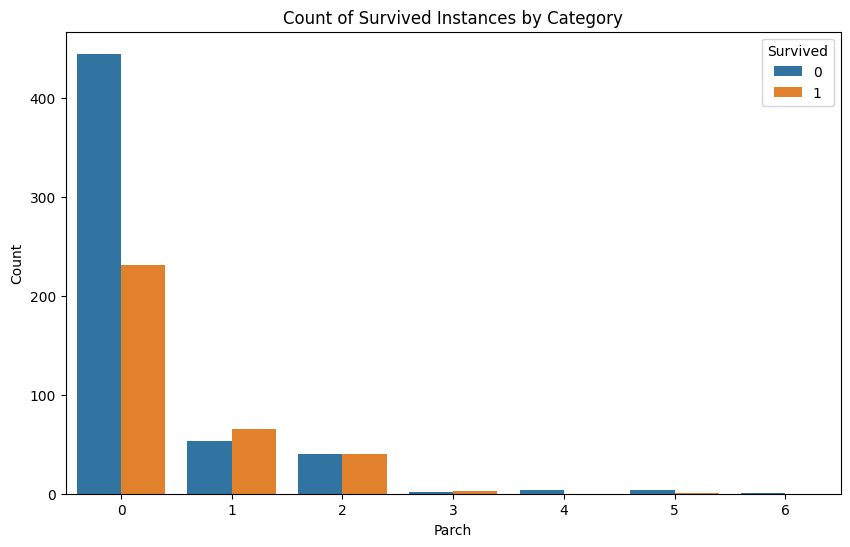

In [60]:
x_axis = 'Parch'
y_axis = 'Survived'
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x=x_axis, hue=y_axis)
plt.xlabel(x_axis)
plt.ylabel('Count')
plt.title(f'Count of {y_axis} Instances by Category')
plt.legend(title=y_axis)
plt.show()

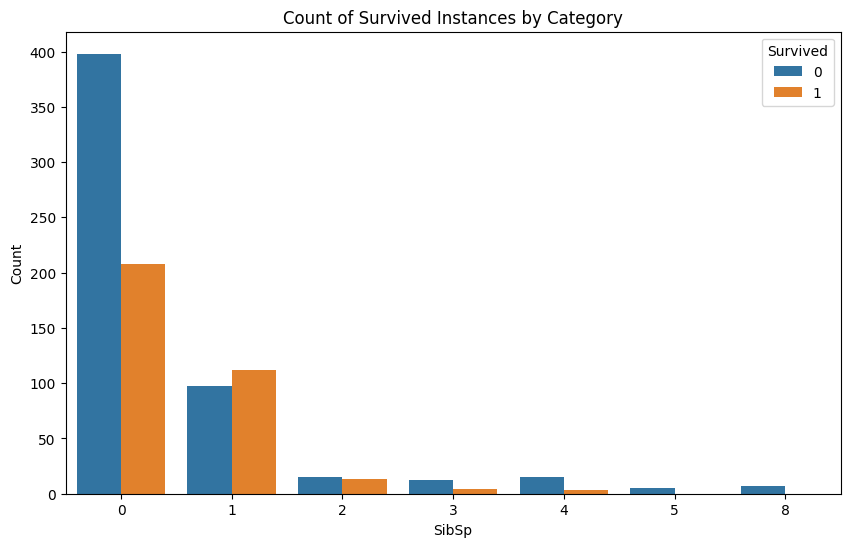

In [59]:
x_axis = 'SibSp'
y_axis = 'Survived'
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x=x_axis, hue=y_axis)
plt.xlabel(x_axis)
plt.ylabel('Count')
plt.title(f'Count of {y_axis} Instances by Category')
plt.legend(title=y_axis)
plt.show()

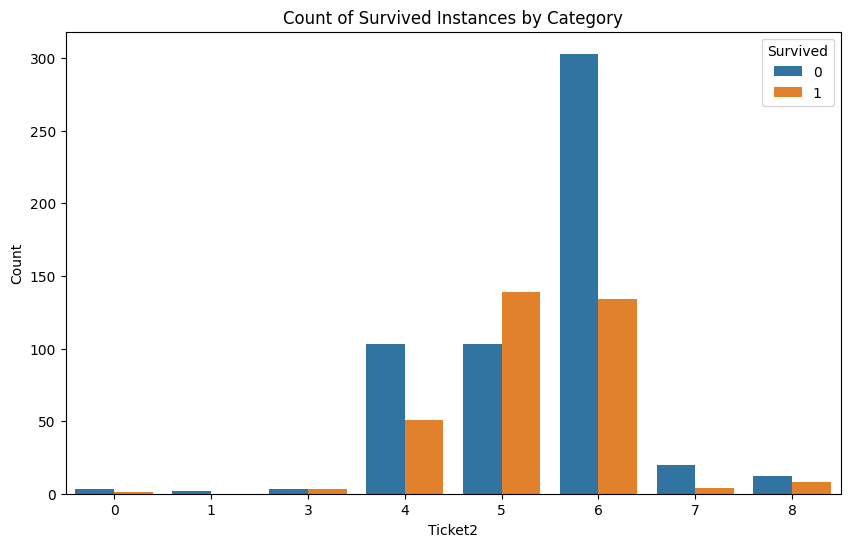

In [58]:
x_axis = 'Ticket2'
y_axis = 'Survived'
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x=x_axis, hue=y_axis)
plt.xlabel(x_axis)
plt.ylabel('Count')
plt.title(f'Count of {y_axis} Instances by Category')
plt.legend(title=y_axis)
plt.show()

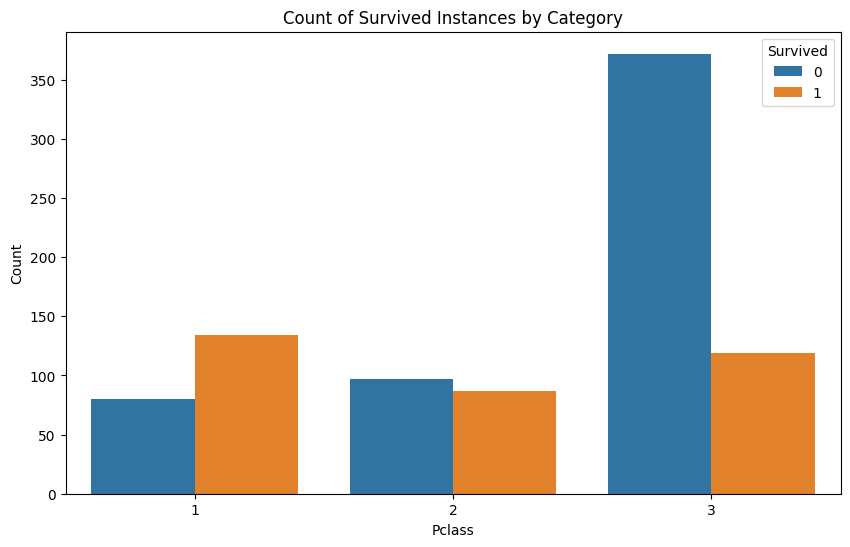

In [57]:
x_axis = 'Pclass'
y_axis = 'Survived'
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x=x_axis, hue=y_axis)
plt.xlabel(x_axis)
plt.ylabel('Count')
plt.title(f'Count of {y_axis} Instances by Category')
plt.legend(title=y_axis)
plt.show()

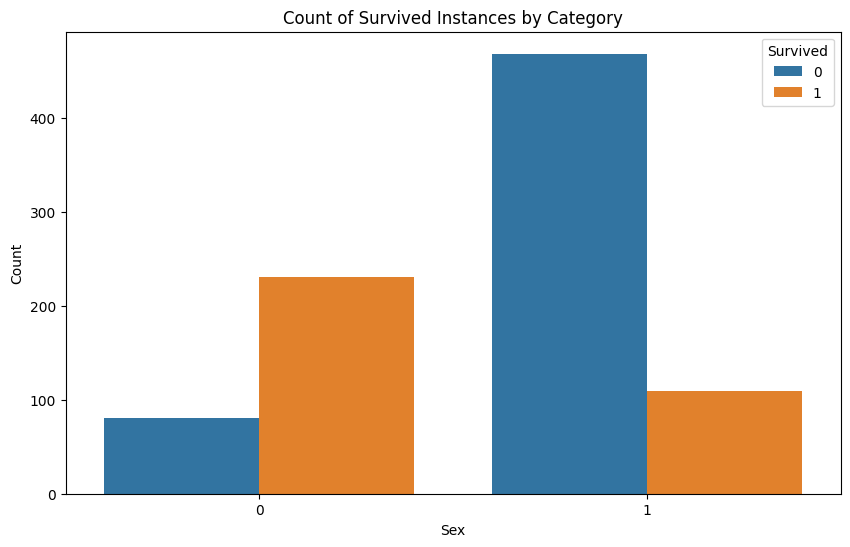

In [49]:
x_axis = 'Sex'
y_axis = 'Survived'
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x=x_axis, hue=y_axis)
plt.xlabel(x_axis)
plt.ylabel('Count')
plt.title(f'Count of {y_axis} Instances by Category')
plt.legend(title=y_axis)
plt.show()

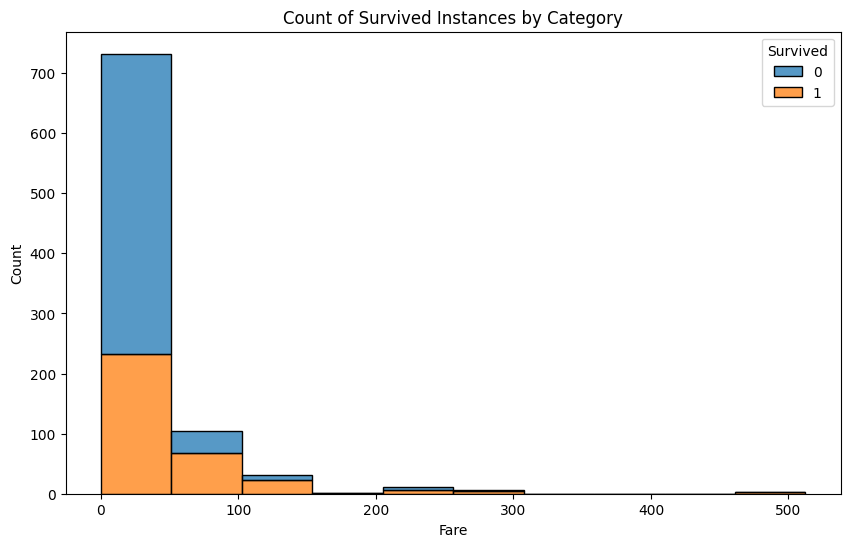

In [56]:
x_axis = 'Fare'
y_axis = 'Survived'
# Plotting
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x=x_axis, hue=y_axis, multiple='stack', bins=10)
plt.xlabel(x_axis)
plt.ylabel('Count')
plt.title(f'Count of {y_axis} Instances by Category')
plt.show()

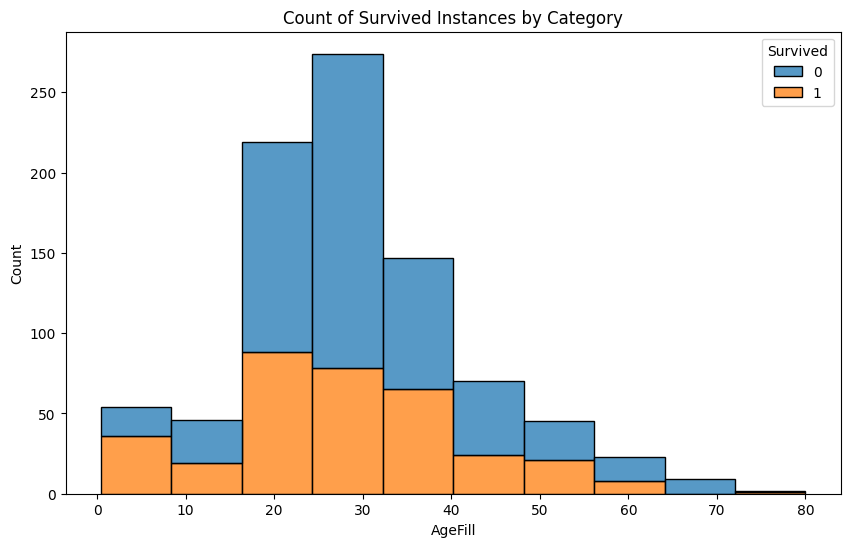

In [61]:
x_axis = 'AgeFill'
y_axis = 'Survived'
# Plotting
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x=x_axis, hue=y_axis, multiple='stack', bins=10)
plt.xlabel(x_axis)
plt.ylabel('Count')
plt.title(f'Count of {y_axis} Instances by Category')
plt.show()

In [43]:
predictions = model.predict(X_val)

print(sklearn.metrics.classification_report(y_val, predictions))
print(sklearn.metrics.roc_auc_score(y_val, predictions))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84        96
           1       0.67      0.71      0.69        49

    accuracy                           0.79       145
   macro avg       0.76      0.77      0.76       145
weighted avg       0.79      0.79      0.79       145

0.7686011904761906


In [ ]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import GridSearchCV

# # Define the model
# rf = RandomForestClassifier(random_state = 42)

# # Define the parameter grid
# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_features': ['auto'],
#     'max_depth': [None],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'bootstrap': [True]
# }

# # Setup the grid search
# grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
#                            cv=5, n_jobs=-1, verbose=2, scoring='roc_auc')

# # Fit the grid search
# grid_search.fit(X_train, y_train)

# # Print the best parameters
# print(f"Best parameters: {grid_search.best_params_}")
# print(f"Best score: {grid_search.best_score_}")

In [ ]:


def preprocess(df):
    df['AgeFill'] = df['Age']
    df['AgeFill'] = df['AgeFill'].groupby([df['Sex'], df['Pclass']], group_keys=False).apply(lambda x: x.fillna(x.median()))
    
    df['Cabin'] = df['Cabin'].fillna('missing').apply(lambda x : cabin_clean(x))
    

    df["Ticket"] = df["Ticket"].apply(lambda x : clean_ticket(x))
    df["Ticket1"] = df["Ticket"].apply(lambda x : x.split(" ")[0].strip().replace("SCBASLE", "SC"))
    df["Ticket2"] = df["Ticket"].apply(lambda x : x.split(" ")[1].strip())
    
    df['Fare'] = df['Fare'].groupby([df['Sex'], df['Pclass'], df['Ticket']], group_keys=False).apply(lambda x: x.fillna(x.mean()))
    
    df["Sex"] = df["Sex"].map({"male":1, "female":0})
    df["Ticket2"] = df["Ticket2"].apply(lambda x: [int(s) for s in x if s.isdigit()][0])
    
    return df

In [ ]:
test = pd.read_csv("test.csv")
test.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


In [ ]:
test = preprocess(test)
test.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    int64  
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         418 non-null    float64
 9   Cabin        418 non-null    object 
 10  Embarked     418 non-null    object 
 11  AgeFill      418 non-null    float64
 12  Ticket1      418 non-null    object 
 13  Ticket2      418 non-null    int64  
dtypes: float64(3), int64(6), object(5)
memory usage: 45.8+ KB


In [ ]:
final_cols = ["Pclass", "Sex", "AgeFill", "SibSp", "Parch", "Fare", "Ticket2"]

X_test = test[final_cols].values
X_test.shape

(418, 7)

In [ ]:
test[final_cols].head()

,Pclass,Sex,AgeFill,SibSp,Parch,Fare,Ticket2
0,3,1,34.5,0,0,7.8292,6
1,3,0,47.0,1,0,7.0000,6
2,2,1,62.0,0,0,9.6875,6
3,3,1,27.0,0,0,8.6625,6
4,3,0,22.0,1,1,12.2875,7


In [ ]:
model = RandomForestClassifier(random_state = 42)
model.fit(X, y)
predictions = model.predict(X_test)

test["Survived"] = predictions
len(predictions)

418

In [ ]:
test[["PassengerId", "Survived"]].head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,1
4,896,1


In [ ]:
test[["PassengerId", "Survived"]].to_csv('submission.csv', index=False)

In [ ]:
# # import the modules we'll need
# from IPython.display import HTML
# import pandas as pd
# import numpy as np
# import base64

# def create_download_link(df, title = "Download CSV file", filename = "data.csv"):  
#     csv = df.to_csv(index=False)
#     b64 = base64.b64encode(csv.encode())
#     payload = b64.decode()
#     html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
#     html = html.format(payload=payload,title=title,filename=filename)
#     return HTML(html)


# # create a link to download the dataframe
# create_download_link(test[["PassengerId", "Survived"]])

In [ ]:
# import joblib
# joblib.dump(model, 'titanic_model.pkl')
# model = joblib.load('titanic_model.pkl')

In [ ]:
# from IPython.display import FileLink
# FileLink(r'titanic_model.pkl')

In [ ]:
import gzip, pickle, pickletools
filepath = "titanic_model.pkl"
with gzip.open(filepath, "wb") as f:
    pickled = pickle.dumps(model)
    f.write(pickled)

In [ ]:
with gzip.open(filepath, 'rb') as f:
    p = pickle.Unpickler(f)
    model = p.load()

In [ ]:
model

RandomForestClassifier(random_state=42)

In [ ]:
# !pip freeze

In [ ]:
import re
import nbformat

def extract_imported_packages_from_notebook(notebook_path):
    with open(notebook_path, 'r') as file:
        notebook = nbformat.read(file, as_version=4)

    imported_packages = set()
    import_re = re.compile(r'^\s*import\s+([^\s]+)', re.MULTILINE)
    from_import_re = re.compile(r'^\s*from\s+([^\s]+)', re.MULTILINE)

    for cell in notebook.cells:
        if cell.cell_type == 'code':
            cell_text = cell.source

            for match in import_re.finditer(cell_text):
                package = match.group(1).split('.')[0]
                imported_packages.add(package)

            for match in from_import_re.finditer(cell_text):
                package = match.group(1).split('.')[0]
                imported_packages.add(package)

    return imported_packages

# Path to your Jupyter notebook
notebook_file_path = r'C:\Users\sonia\Downloads\Extra\titanic\titanic_notebook.ipynb'  # Replace with your notebook file path

# Extract the imported packages
imported_packages = extract_imported_packages_from_notebook(notebook_file_path)
imported_packages = [i.replace(",", "") for i in imported_packages]

# Print the imported packages
print("Imported packages:", imported_packages)

Imported packages: ['re', 'pandas', 'scipy', 'plotly', 'sklearn', 'nbconvert', 'xgboost', 'random', 'gzip', 'dcor', 'nbformat', 'numpy']


In [ ]:
import subprocess
import os

def generate_requirements_file(directory):
    try:
        # Run `pipreqs` command to generate requirements.txt
        subprocess.run(['pipreqs', '--force', '--ignore', 'tests', directory], check=True)
        print("requirements.txt has been generated.")
    except subprocess.CalledProcessError as e:
        print(f"Error occurred while running pipreqs: {e}")

def get_package_names_from_requirements():
    requirements_file = 'requirements.txt'
    package_names = set()
    
    if os.path.exists(requirements_file):
        try:
            with open(requirements_file, 'r') as file:
                lines = file.readlines()
                for line in lines:
                    if '==' in line:
                        name, _ = line.strip().split('==')
                        package_names.add(name)
        except IOError as e:
            print(f"Error reading {requirements_file}: {e}")
    else:
        print(f"{requirements_file} does not exist.")
    
    return package_names

# Example usage
project_directory = '.'  # Replace with your project directory
generate_requirements_file(project_directory)
installed_package_names = list(get_package_names_from_requirements())
print(installed_package_names)

requirements.txt has been generated.
['Flask', 'pandas', 'scipy', 'plotly', 'nbconvert', 'xgboost', 'dcor', 'scikit_learn', 'nbformat', 'numpy']


In [ ]:
from importlib.metadata import version
no_match = []
for i in set(installed_package_names + imported_packages):
    try:
        print(i, version(i))
    except:
        no_match.append(i)

final_no_match = set(no_match) - set(installed_package_names).intersection(set(no_match))
final_no_match

pandas 2.2.2
scipy 1.14.0
plotly 5.23.0
xgboost 2.1.1
nbformat 5.10.4
dcor 0.6
scikit_learn 1.5.1
nbconvert 7.16.4
numpy 2.0.1


{'gzip', 'random', 're', 'sklearn'}